In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
from read_results import read_varnames
import saprc99_code.kpp4py as kpp

nvar = 74
varnames = read_varnames("saprc99_code/saprc99_Parameters.f90")[0:nvar]
print(varnames)

['H2SO4', 'HCOOH', 'CCO_OH', 'RCO_OH', 'CCO_OOH', 'RCO_OOH', 'XN', 'XC', 'SO2', 'O1D', 'ALK1', 'BACL', 'PAN', 'PAN2', 'PBZN', 'MA_PAN', 'H2O2', 'N2O5', 'HONO', 'ALK2', 'ALK3', 'TBU_O', 'ALK5', 'ARO2', 'HNO4', 'COOH', 'HOCOO', 'BZNO2_O', 'MEOH', 'ALK4', 'ARO1', 'DCB2', 'DCB3', 'CRES', 'DCB1', 'NPHE', 'ROOH', 'BALD', 'PHEN', 'CO', 'MGLY', 'ACET', 'HNO3', 'ETHENE', 'GLY', 'BZ_O', 'ISOPRENE', 'R2O2', 'TERP', 'METHACRO', 'OLE1', 'ISOPROD', 'OLE2', 'MVK', 'CCHO', 'HCHO', 'RNO3', 'O3P', 'RCHO', 'MEK', 'PROD2', 'O3', 'HO2', 'RO2_N', 'MA_RCO3', 'C_O2', 'BZCO_O2', 'RO2_R', 'NO', 'NO2', 'NO3', 'CCO_O2', 'RCO_O2', 'OH']


In [3]:
df_range = (
    pd.read_csv('saprc99_range.csv', index_col=0)
    .append(pd.DataFrame(np.array([[0.0, 1.0]]), 
                         columns=['min','max'], 
                         index=['SUN']
                        )
           )
)

df_range['mid'] = 0.5*(df_range['min']+df_range['max'])
df_range['span'] = df_range['max'] - df_range['min']
df_range.tail(10)

,min,max,mid,span
C_O2,5.391452e+06,1.419437e+09,7.124145e+08,1.414046e+09
BZCO_O2,1.000000e-08,3.226580e+06,1.613290e+06,3.226580e+06
RO2_R,2.006049e+05,1.824368e+09,9.122844e+08,1.824168e+09
NO,1.006610e+05,9.000156e+11,4.500078e+11,9.000155e+11
NO2,5.003760e+09,1.461165e+12,7.330842e+11,1.456161e+12
NO3,1.742790e+06,1.039629e+10,5.199017e+09,1.039455e+10
CCO_O2,6.779490e+05,5.267318e+08,2.637049e+08,5.260539e+08
RCO_O2,7.110903e+04,3.979400e+08,1.990056e+08,3.978689e+08
OH,9.784155e+04,7.272688e+07,3.641236e+07,7.262904e+07
SUN,0.000000e+00,1.000000e+00,5.000000e-01,1.000000e+00


In [4]:
df_range.loc[['PAN', 'ARO2', 'ARO1', 'HCHO', 'O3', 'NO', 'NO2', 'SUN']]

,min,max,mid,span
PAN,6.560740e+07,4.865127e+11,2.432891e+11,4.864471e+11
ARO2,1.000000e-08,1.323908e+11,6.619542e+10,1.323908e+11
ARO1,1.000000e-08,2.594001e+11,1.297000e+11,2.594001e+11
HCHO,1.708487e+10,6.853611e+11,3.512230e+11,6.682763e+11
O3,8.459007e+11,8.609433e+12,4.727667e+12,7.763533e+12
NO,1.006610e+05,9.000156e+11,4.500078e+11,9.000155e+11
NO2,5.003760e+09,1.461165e+12,7.330842e+11,1.456161e+12
SUN,0.000000e+00,1.000000e+00,5.000000e-01,1.000000e+00


# Make training data

In [5]:
y0_list = np.random.uniform(df_range['min'] + 0.3*df_range['span'],
                            df_range['max'] - 0.3*df_range['span'], 
                           size=(5000, nvar+1))

y0_list.shape

(5000, 75)

In [6]:
%time y1_list = kpp.onestep(y0_list.T).T
y1_list.shape

CPU times: user 3.87 s, sys: 53.1 ms, total: 3.92 s
Wall time: 3.95 s


(5000, 74)

# Normalize data

In [7]:
normalizer = StandardScaler()
normalizer.fit(y0_list[:,0:74])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
X_train = np.append(normalizer.transform(y0_list[:,0:74]), 
                    y0_list[:,-1:], 
                    axis=1)
X_train.shape

(5000, 75)

In [9]:
Y_train = normalizer.transform(y1_list)
Y_train.std(axis=0)

array([ 1.00069434,  1.00312529,  1.00000016,  1.00003796,  0.99998769,
        1.00000909,  1.11033155,  1.07917099,  0.98024212,  0.92758943,
        0.99451683,  1.06055229,  0.90048777,  0.94184393,  0.98623844,
        1.45376268,  0.95089258,  1.34251002,  0.20765175,  0.97863225,
        0.95361963,  0.95316403,  0.84941654,  0.67314026,  0.98748871,
        0.89012201,  0.8777173 ,  3.68603741,  0.98054869,  0.92250588,
        0.89405884,  0.9395708 ,  1.16583082,  0.20296725,  0.62049098,
        1.25511611,  0.81100285,  0.74954169,  0.33096397,  0.99905162,
        0.72028927,  1.0003427 ,  1.01611884,  0.83337886,  0.75030207,
        0.6319963 ,  0.20559164,  0.59993794,  0.02565669,  0.63896028,
        0.54264851,  0.52527404,  0.09128996,  0.81075727,  0.76145445,
        0.75601938,  0.93804881,  0.74615177,  0.7237472 ,  0.97892012,
        0.84640396,  0.97160189,  0.83386661,  0.69360875,  0.65083941,
        0.22289046,  0.24082827,  0.45307374,  0.12726592,  1.12

# Fit ANN

In [10]:
x_torch = Variable(torch.from_numpy(X_train).type(torch.FloatTensor))
y_torch = Variable(torch.from_numpy(Y_train).type(torch.FloatTensor))

In [11]:
H1, H2 = 100, 100

model = torch.nn.Sequential(
    torch.nn.Linear(75, H1),
    torch.nn.ReLU(),
    #torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H1),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    #torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H2),
    torch.nn.Linear(H2, 74)
)

In [12]:
loss_fn = torch.nn.MSELoss()

#optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

for t in range(4000):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%200==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.data[0])

200 0.31468871235847473
400 0.13196852803230286
600 0.07141710072755814
800 0.04009559378027916
1000 0.023616518825292587
1200 0.0151762580499053
1400 0.011193583719432354
1600 0.008936220780014992
1800 0.007656843867152929
2000 0.0066921524703502655
2200 0.0061058769933879375
2400 0.005630237981677055
2600 0.005277880001813173
2800 0.005070209037512541
3000 0.0048740156926214695
3200 0.004631736781448126
3400 0.004352475982159376
3600 0.004076881799846888
3800 0.004979826509952545
4000 0.0041444008238613605


In [13]:
%%time 
y_pred = model(x_torch)
y_pred_numpy = y_pred.data.numpy()

CPU times: user 14.5 ms, sys: 899 µs, total: 15.4 ms
Wall time: 6.17 ms


In [14]:
r2_score(y_pred_numpy, Y_train)

0.9670646720482049

(-20, 20)

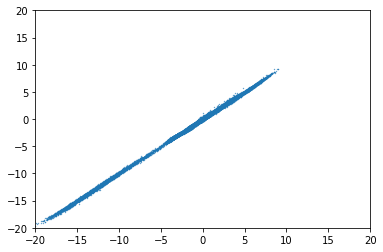

In [15]:
plt.scatter(y_pred_numpy.ravel(), Y_train.ravel(), s=0.1)
plt.xlim(-20,20)
plt.ylim(-20,20)

# Test set

In [23]:
y0_test = np.random.uniform(df_range['min'] + 0.3*df_range['span'],
                           df_range['max'] - 0.3*df_range['span'], 
                           size=(5000, nvar+1))

y0_list.shape

(5000, 75)

In [24]:
%time y1_test = kpp.onestep(y0_test.T).T

CPU times: user 3.69 s, sys: 52.5 ms, total: 3.74 s
Wall time: 3.78 s


In [25]:
X_test = np.append(normalizer.transform(y0_test[:,0:74]), 
                   y0_test[:,-1:], 
                   axis=1)
Y_test = normalizer.transform(y1_test)

In [26]:
%%time
X_torch_test = Variable(torch.from_numpy(X_test).type(torch.FloatTensor))
y_test_pred = model(X_torch_test).data.numpy()

CPU times: user 12.1 ms, sys: 975 µs, total: 13 ms
Wall time: 6.95 ms


In [27]:
r2_score(y_test_pred, Y_test)

0.95816069702127094

(-20, 20)

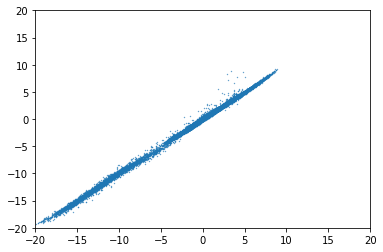

In [28]:
plt.scatter(y_test_pred, Y_test, s=0.1)
plt.xlim(-20,20)
plt.ylim(-20,20)

(-20, 20)

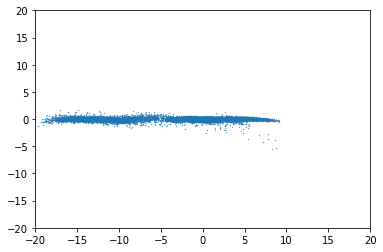

In [29]:
plt.scatter(Y_test, y_test_pred-Y_test, s=0.1)
plt.xlim(-20,20)
plt.ylim(-20,20)